In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as scs

!whoami
!date

ndbs
Fri Jun 26 23:29:21 PDT 2020


# Goal: Get an idea what birthweight shifts to expect in each country

## 1. Define function to sample flour consumption in the population

In [2]:
def sample_flour_consumption(sample_size):
    """Distribution for daily flour consumption (from Ethiopia)"""
    # Define quantiles in g of flour per day
    q0 = 0
    q1 = 77.5
    q2 = 100
    q3 = 200
    q4 = 350.5

    daily_flour_consumption = np.empty(sample_size) # to store the returned sample
    u = np.random.uniform(0,1,size=sample_size) # one random number for each returned value

    # Define the distribution to be uniform between each quantile
    for i in range(sample_size):
        if u[i] <= 0.25:
            daily_flour_consumption[i] = np.random.uniform(q0,q1)
        elif u[i] <= 0.5:
            daily_flour_consumption[i] = np.random.uniform(q1,q2)
        elif u[i] <= 0.75:
            daily_flour_consumption[i] = np.random.uniform(q2,q3)
        else:
            daily_flour_consumption[i] = np.random.uniform(q3,q4)
        
    return daily_flour_consumption

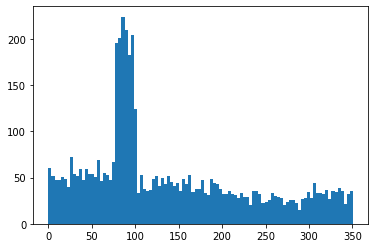

In [3]:
flour_consumption = sample_flour_consumption(5000)
plt.hist(flour_consumption, bins=100)
plt.show()

In [4]:
flour_consumption.mean()

139.79055258052588

In [5]:
flour_consumption.std()

93.48125035699711

## 2. Define other input data for birthweight shift - dose response and iron consumption

### Dose response for iron on birthweight

15.1 grams (95% CI: 6.0, 24.2) per 10 mg of daily iron consumptionn (use normal distribution)

In [6]:
# Define normal distribution for dose-response on birthweight

# mean and 0.975-quantile of normal distribution for mean difference (MD)
mean = 15.1 # g per 10 mg daily iron
q_975 = 24.2 # 97.5th percentile

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = scs.norm().ppf(0.975)

std = (q_975 - mean) / q_975_stdnorm # std dev of normal distribution

# Frozen normal distribution for MD, representing uncertainty in our effect size
dose_response_distribution = scs.norm(mean, std)

# # random sample from effect size distribution
# bw_md_per_10_mg_iron = dose_response_distribution.rvs()

In [7]:
dose_response = dose_response_distribution.rvs()
dose_response

17.44382989410483

### Iron concentration in flour for each country

Ethiopia: 30 mg iron as NaFeEDTA / kg flour;
    use point value

India: 14 to 21.25 mg iron as NaFeEDTA / kg flour;
    sample from uniform distribution with range: 14 - 21.25 (mean 17.625)

Nigeria: 40 mg iron as NaFeEDTA / kg flour;
    use point value
  

In [8]:
# Define India's flour distribution
india_min = 14 # mg iron as NaFeEDTA per kg Flour
india_max = 21.25
scale = india_max-india_min
india_iron_conc_distribution = scs.uniform(loc=india_min, scale=scale)
india_iron_conc_distribution.mean()

17.625

In [9]:
india_iron_concentration = india_iron_conc_distribution.rvs()
india_iron_concentration

20.924293414921955

In [10]:
# Define degenerate distributions to sample iron concentration in Ethiopia and Nigreia
# (We define distributions for consistency with India in the "multiple draws" function below)
ethiopia_iron_conc_distribution = scs.bernoulli(p=0,loc=30) # 30 mg iron as NaFeEDTA per kg flour
nigeria_iron_conc_distribution = scs.bernoulli(p=0,loc=40) # 40 mg iron as NaFeEDTA per kg flour

In [11]:
print(ethiopia_iron_conc_distribution.rvs(5))
print(nigeria_iron_conc_distribution.rvs(5))

[30 30 30 30 30]
[40 40 40 40 40]


## 3. Define function to compute birthweight shift, and plot the distribution of shifts

The following plot is for India, for a single draw of India's iron_concentration distribution and a single draw of dose_response.

In [12]:
def birthweight_shift(dose_response, iron_concentration, daily_flour):
    """
    Computes the increase in birthweight (in grams) given the following:
    
    dose_response: g of birthweight increase per 10 mg daily iron
    iron_concentration: mg iron as NaFeEDTA per kg flour
    daily flour: g of iron eaten per day by pregnant mother
    """
    return (dose_response/10)*(iron_concentration)*(daily_flour/1_000)

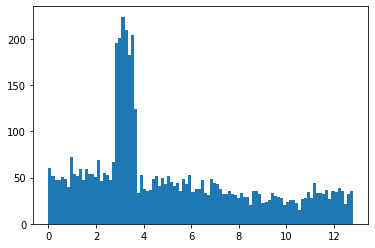

In [13]:
bw_shifts = birthweight_shift(dose_response, india_iron_concentration, flour_consumption)
plt.hist(bw_shifts, bins=100)
plt.show()

In [14]:
print(bw_shifts.mean(), bw_shifts.std())

5.102352582843612 3.412063908479903


## 4. Get an idea of the range of possible mean birthweight shifts in India (one draw at a time)

Print the mean and standard deviation of the birthweight shift for several draws of the dose response and of India's iron_concentration distribution. Plot the birthweight shift distribution for the final draw.

In [15]:
for i in range(20):
    dose_response = dose_response_distribution.rvs()
    india_iron_concentration = india_iron_conc_distribution.rvs()
    bw_shifts = birthweight_shift(dose_response, india_iron_concentration, flour_consumption)
    print(bw_shifts.mean(), bw_shifts.std())

4.197147943054626 2.8067321461085886
4.181861824491562 2.7965099569119523
3.5734423881483455 2.389645482876053
2.4066537430092105 1.6093863062974227
2.25646935844803 1.5089544545470128
3.9781049909486743 2.6602529408493005
3.1478980767241707 2.105073932224776
2.8583742609534433 1.911462505652971
3.2878794233373383 2.1986827710661356
1.8569166112162303 1.241764077906316
3.3162579996652974 2.217660196575352
4.731875526324881 3.164317134233476
6.017345890433405 4.023941584637641
3.749530008114534 2.507399441086819
3.1584508986782485 2.1121308539755765
4.63682312777737 3.1007533461117105
3.3105514037439963 2.213844060848311
4.224921469292494 2.8253049603053357
3.1820137314926478 2.1278878778429373
2.532355933234121 1.6934463353760596


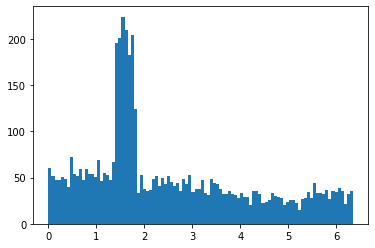

In [16]:
# Plot the final distribution of birthweight shifts (one draw) for India
plt.hist(bw_shifts, bins=100)
plt.show()

## 5. Plot the overall distribution including parameter uncertainty (multiple draws together)

### Define a function to sample the birthweight shifts for multiple draws

Essentially this puts the above for loop into a function.

In [17]:
def birthweight_shift_across_draws(dose_response_distribution,
                                   iron_conc_distribution,
                                   population_size,
                                   num_draws,
                                   ):
    """
    Sample the distribution of birthweight shifts for a given population size and number of draws.
    
    Each "draw" corresponds to one draw from `dose_response_distribution` and `iron_conc_distribution`,
    so these will both be sampled `num_draws` times.
    
    The `population_size` is the sample size passed to `sample_flour_consumption()`; each draw will yield
    `population_size` birthweight samples.
    
    The returned sample will have shape (num_draws, population_size), so each row corresponds to a
    draw and contains the sampled birthweight shifts for the population based on that draw.
    """
    bw_shifts = np.empty((num_draws, population_size))
    dose_response = dose_response_distribution.rvs(num_draws)
    iron_concentration = iron_conc_distribution.rvs(num_draws)
    for i in range(num_draws):
        daily_flour = sample_flour_consumption(population_size)
        bw_shifts[i] = birthweight_shift(dose_response[i], iron_concentration[i], daily_flour)
    
    return bw_shifts

### For each country, plot the distribution of birthweight shifts for all draws together

Each row of the `bw_shifts` array returned by the above function has a distribution with the same shape as the flour consumption distribution, but scaled by a slightly different factor according to the draws of the dose response and iron concentration distributions.

Calling `.flatten()` on `bw_shifts` combines all rows into a single sample. This gives an idea of the mean and spread of birthweight shifts across draws. This combined sample represents the mixture distribution whose components are the rows of `bw_shifts` -- the mixing distribution is the joint distribution of dose response and iron concentration.

It would be better to write a function to draw the three graphs below and add labels, rather than copying the same code three times...

In [18]:
# sample size = population_size x num_draws
1_000*25

25000

### Plot order: India, Ethiopia, Nigeria

In [19]:
# India
bw_shifts = birthweight_shift_across_draws(
    dose_response_distribution,
    india_iron_conc_distribution,
    population_size=1_000,
    num_draws=25,
)
bw_shifts.flatten().mean()

3.6298677457511728

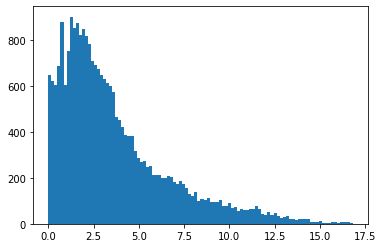

In [20]:
# India
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

In [21]:
# Ethiopia
bw_shifts = birthweight_shift_across_draws(
    dose_response_distribution,
    ethiopia_iron_conc_distribution,
    population_size=1_000,
    num_draws=25,
)
bw_shifts.flatten().mean()

6.273848988107496

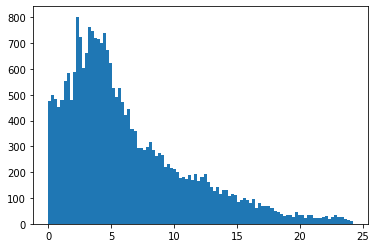

In [22]:
# Ethiopia
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

In [23]:
# Nigeria
bw_shifts = birthweight_shift_across_draws(
    dose_response_distribution,
    nigeria_iron_conc_distribution,
    population_size=1_000,
    num_draws=25,
)
bw_shifts.flatten().mean()

8.15267846139869

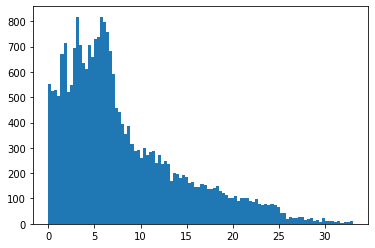

In [24]:
# Nigeria
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

## 6. Just for kicks, try to get a better idea what the actual mixture distribution looks like

1 million sample points!

In [25]:
# Note that the above 3 graphs have a sharp cutoff at 0...
# How likely are we to get a negative dose response sometimes?
# Not very likely with only 25 draws...
# But in theory the underlying distribution is unbounded below and above.
print(dose_response_distribution.rvs(25).min())
print(dose_response_distribution.rvs(1000).min())
print(dose_response_distribution.rvs(5000).min())

8.780700270689247
0.39478240459821556
-1.8676796914967309


mean = 8.376978642492784


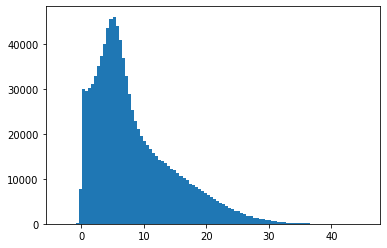

In [26]:
# Nigeria
bw_shifts = birthweight_shift_across_draws(
    dose_response_distribution,
    nigeria_iron_conc_distribution,
    population_size=100,
    num_draws=10_000,
)
print("mean =",bw_shifts.flatten().mean())
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

mean = 3.6609467232648742


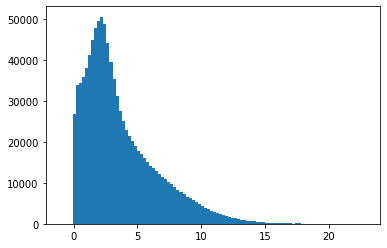

In [27]:
# India
bw_shifts = birthweight_shift_across_draws(
    dose_response_distribution,
    india_iron_conc_distribution,
    population_size=100,
    num_draws=10_000,
)
print("mean =",bw_shifts.flatten().mean())
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

In [28]:
bw_shifts.flatten().min()

-1.0036780397185034